In [1]:
!nvidia-smi

Sat Aug 20 16:13:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Used to build and deploy machine learning apps
import tensorflow as tf

# Deep Learning API for creating Neural Networks (Runs on TensorFlow)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Scikit-learn : machine learning library
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Used for accessing files and file names
import pathlib 
import os

In [4]:
def display_random_image(dir, class_type):
  img_dir = dir + '/' + class_type
  files = os.listdir(img_dir)
  img_name = random.choice(files)
  img = mpimg.imread(img_dir + '/' + img_name)
  plt.imshow(img)
  plt.title(class_type)
  plt.axis('off')
  print(f"Image shape : {img.shape}")

Image shape : (512, 512, 3)


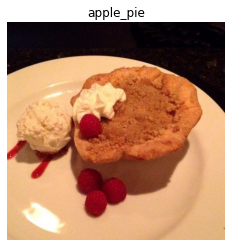

In [9]:
display_random_image("/content/drive/MyDrive/data/food_images", "apple_pie")

Image shape : (384, 512, 3)


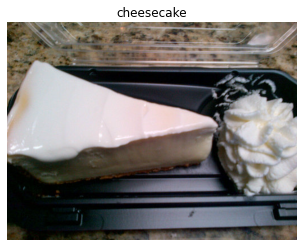

In [10]:
display_random_image("/content/drive/MyDrive/data/food_images", "cheesecake")

Image shape : (382, 512, 3)


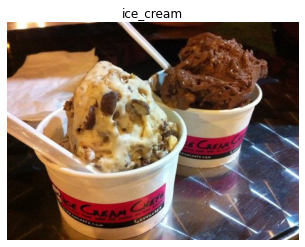

In [11]:
display_random_image("/content/drive/MyDrive/data/food_images", "ice_cream")

In [35]:
data_dir = "/content/drive/MyDrive/data/food_images"
# Import data, turn it into batches of 32 with a size of 256x256
# Batch : We loop through batches of 32 images to minimize 
# memory requirements
# Works with PNG, JPG, BMP, PPM, TIF files

training_data = tf.keras.utils.image_dataset_from_directory(data_dir, 
                                            validation_split=0.2,
                                            subset="training",
                                            batch_size=32, #32 is magical number for processing
                                            image_size=(256,256),
                                            label_mode='categorical',
                                            seed=66)

validation_data = tf.keras.utils.image_dataset_from_directory(data_dir, 
                                            validation_split=0.2,
                                            subset="validation",
                                            batch_size=32, 
                                            image_size=(256,256),
                                            label_mode='categorical',
                                            seed=66)

Found 20000 files belonging to 20 classes.
Using 16000 files for training.
Found 20000 files belonging to 20 classes.
Using 4000 files for validation.


In [36]:
# Normalize pixel values between 0 & 1
# Each pixel is currently values between 0 & 255 for RGB colors
# Neural networks work best with normalized data
# Divide all values by the max value 255
norm_layer = tf.keras.layers.Rescaling(1/255.)

# Apply the division to all data in traing data set
training_data_norm = training_data.map(lambda x, y: (norm_layer(x), y))

# Do same for test (validation) dataset
validation_data_norm = validation_data.map(lambda x, y: (norm_layer(x), y))

In [18]:
len(training_data_norm), 16000/32

(500, 500.0)

# **CNN Model**

In [21]:
model_cnn = Sequential([
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(20),
    Activation(activation="softmax") # 20 output neurons
])

model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

hirtory_cnn = model_cnn.fit(training_data_norm,
                            epochs=5,
                            steps_per_epoch=len(training_data_norm),
                            validation_data=validation_data_norm,
                            validation_steps=len(validation_data_norm))

Epoch 1/5
500/500 [==============================] - 2255s 4s/step - loss: 2.8628 - accuracy: 0.1151 - val_loss: 2.7786 - val_accuracy: 0.1427
Epoch 2/5
500/500 [==============================] - 64s 126ms/step - loss: 2.5565 - accuracy: 0.2265 - val_loss: 2.7308 - val_accuracy: 0.1815
Epoch 3/5
500/500 [==============================] - 74s 147ms/step - loss: 1.8232 - accuracy: 0.4508 - val_loss: 3.3988 - val_accuracy: 0.1618
Epoch 4/5
500/500 [==============================] - 65s 128ms/step - loss: 0.7095 - accuracy: 0.7886 - val_loss: 5.8195 - val_accuracy: 0.1310
Epoch 5/5
500/500 [==============================] - 63s 126ms/step - loss: 0.1906 - accuracy: 0.9461 - val_loss: 8.5252 - val_accuracy: 0.1408


In [22]:
model_cnn.evaluate(validation_data_norm)

125/125 [==============================] - 12s 90ms/step - loss: 8.5252 - accuracy: 0.1408


[8.52517032623291, 0.1407500058412552]

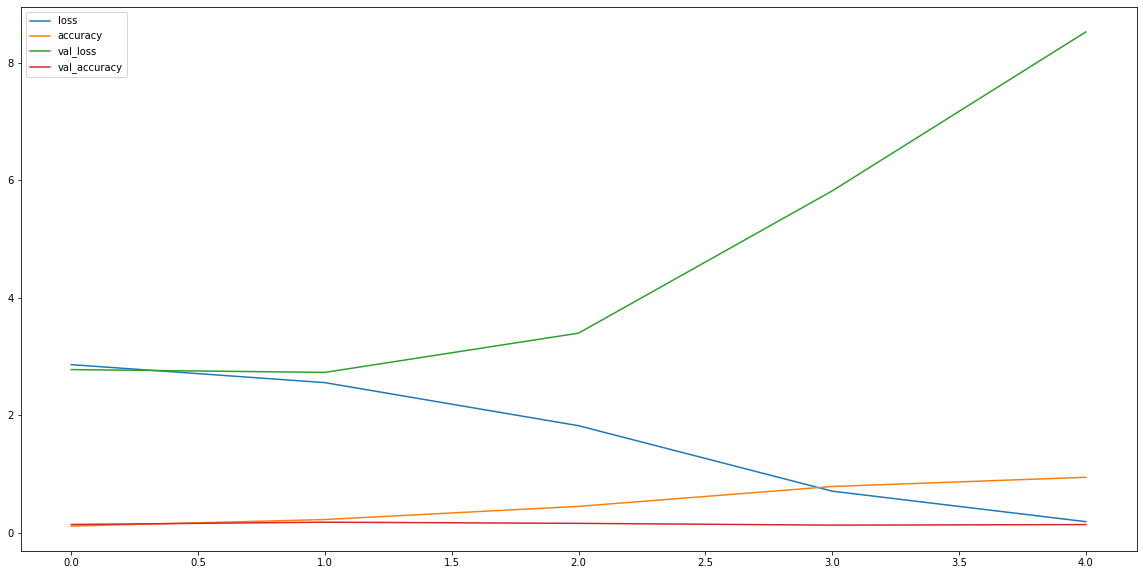

In [23]:
pd.DataFrame(hirtory_cnn.history).plot(figsize=(20,10))

In [24]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [26]:
model_cnn_aug = Sequential([
    data_augmentation,
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(20),
    Activation(activation="softmax") # 20 output neurons
])

model_cnn_aug.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

history_cnn_aug = model_cnn_aug.fit(training_data_norm,
                            epochs=5,
                            steps_per_epoch=len(training_data_norm),
                            validation_data=validation_data_norm,
                            validation_steps=len(validation_data_norm))

Epoch 1/5
500/500 [==============================] - 67s 130ms/step - loss: 2.9219 - accuracy: 0.0911 - val_loss: 2.7948 - val_accuracy: 0.1485
Epoch 2/5
500/500 [==============================] - 65s 128ms/step - loss: 2.7436 - accuracy: 0.1597 - val_loss: 2.6891 - val_accuracy: 0.1752
Epoch 3/5
500/500 [==============================] - 66s 131ms/step - loss: 2.6814 - accuracy: 0.1807 - val_loss: 2.7184 - val_accuracy: 0.1797
Epoch 4/5
500/500 [==============================] - 66s 131ms/step - loss: 2.6220 - accuracy: 0.1956 - val_loss: 2.6316 - val_accuracy: 0.1890
Epoch 5/5
500/500 [==============================] - 65s 129ms/step - loss: 2.5771 - accuracy: 0.2108 - val_loss: 2.6005 - val_accuracy: 0.2010


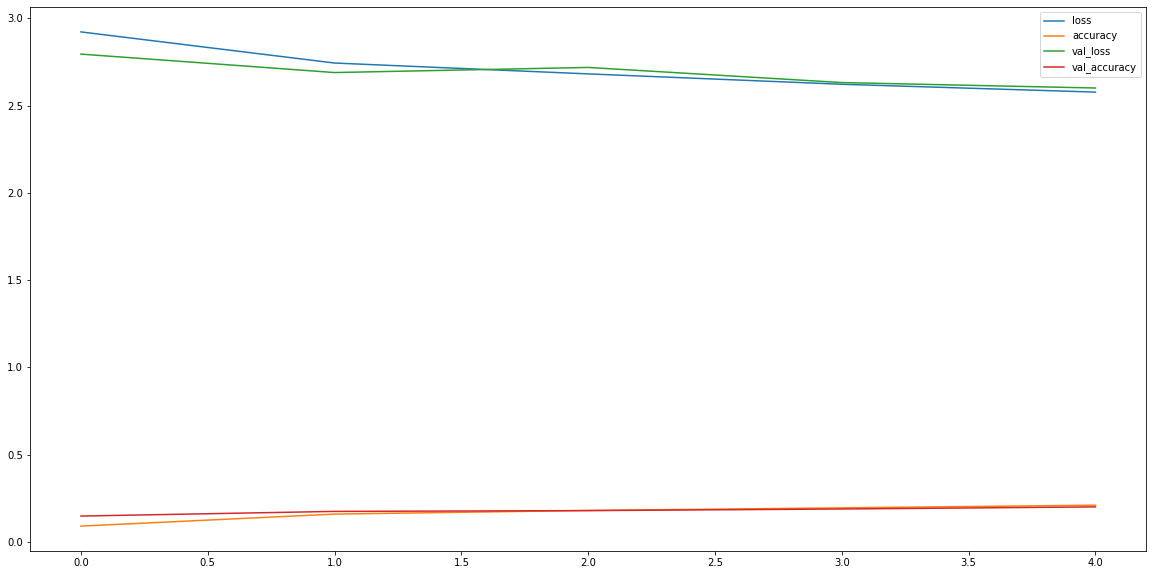

In [27]:
pd.DataFrame(history_cnn_aug.history).plot(figsize=(20,10))

In [25]:
# Get class names
class_names = os.listdir("/content/drive/MyDrive/data/food_images")
class_names.sort()
class_names

['apple_pie',
 'breakfast_burrito',
 'caesar_salad',
 'cheese_plate',
 'cheesecake',
 'chicken_quesadilla',
 'chicken_wings',
 'club_sandwich',
 'cup_cakes',
 'donuts',
 'falafel',
 'fish_and_chips',
 'french_fries',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [28]:
#Normalize and Resize
def normalize_and_resize(img_loc):
  my_img = tf.io.read_file(img_loc) # Read in image
  my_img = tf.image.decode_image(my_img) # Turn file into a tensor
  my_img = tf.image.resize(my_img, size=[256, 256]) # Resize image
  my_img = my_img/255 # Normalize data
  return my_img 

In [30]:
# Make Predictions on Outside Images
# apple_pie = normalize_and_resize("/content/gdrive/MyDrive/data/apple_pie.png")
# # Tells us how likely the image belongs to a class in our model
# prediction = model_cnn_aug.predict(tf.expand_dims(apple_pie, axis=0))
# class_names[np.argmax(prediction)]

In [31]:
import tensorflow_hub as hub

# **ResNet Feature Model**

In [32]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
resnet_layer = hub.KerasLayer(resnet_url,
                              trainable=False,
                              input_shape=(256,256,3))
resnet_model = Sequential([
    resnet_layer,
    Dense(20, activation='softmax')
])

In [33]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [34]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [39]:
resnet_history = resnet_model.fit(training_data_norm,
                                  epochs=5,
                                  steps_per_epoch=len(training_data_norm),
                                  validation_data=validation_data_norm)

Epoch 1/5
500/500 [==============================] - 83s 153ms/step - loss: 1.0927 - accuracy: 0.6796 - val_loss: 0.8642 - val_accuracy: 0.7515
Epoch 2/5
500/500 [==============================] - 77s 152ms/step - loss: 0.6778 - accuracy: 0.7955 - val_loss: 0.7847 - val_accuracy: 0.7753
Epoch 3/5
500/500 [==============================] - 75s 150ms/step - loss: 0.5563 - accuracy: 0.8320 - val_loss: 0.7899 - val_accuracy: 0.7740
Epoch 4/5
500/500 [==============================] - 77s 152ms/step - loss: 0.4743 - accuracy: 0.8602 - val_loss: 0.7929 - val_accuracy: 0.7763
Epoch 5/5
500/500 [==============================] - 83s 165ms/step - loss: 0.4173 - accuracy: 0.8790 - val_loss: 0.7965 - val_accuracy: 0.7732


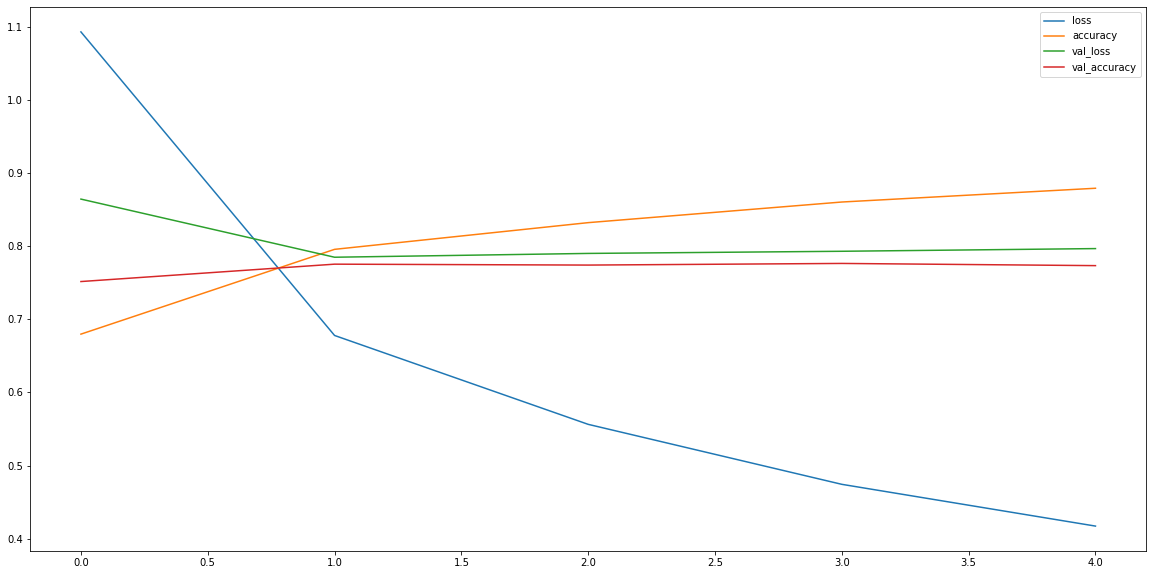

In [40]:
pd.DataFrame(resnet_history.history).plot(figsize=(20,10))

# **Efficient Feature Model**

In [42]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
eff_layer = hub.KerasLayer(eff_url,
                              trainable=False,
                              input_shape=(256,256,3))
eff_model = Sequential([
    eff_layer,
    Dense(20, activation='softmax')
])

In [43]:
eff_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2560)              64097680  
                                                                 
 dense_5 (Dense)             (None, 20)                51220     
                                                                 
Total params: 64,148,900
Trainable params: 51,220
Non-trainable params: 64,097,680
_________________________________________________________________


In [44]:
eff_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [45]:
eff_history = eff_model.fit(training_data_norm,
                                  epochs=5,
                                  steps_per_epoch=len(training_data_norm),
                                  validation_data=validation_data_norm)

Epoch 1/5
500/500 [==============================] - 322s 585ms/step - loss: 0.8371 - accuracy: 0.7706 - val_loss: 0.6172 - val_accuracy: 0.8238
Epoch 2/5
500/500 [==============================] - 289s 576ms/step - loss: 0.5220 - accuracy: 0.8448 - val_loss: 0.5603 - val_accuracy: 0.8363
Epoch 3/5
500/500 [==============================] - 289s 577ms/step - loss: 0.4403 - accuracy: 0.8696 - val_loss: 0.5342 - val_accuracy: 0.8460
Epoch 4/5
500/500 [==============================] - 289s 577ms/step - loss: 0.3879 - accuracy: 0.8854 - val_loss: 0.5222 - val_accuracy: 0.8475
Epoch 5/5
500/500 [==============================] - 290s 578ms/step - loss: 0.3482 - accuracy: 0.8995 - val_loss: 0.5193 - val_accuracy: 0.8487


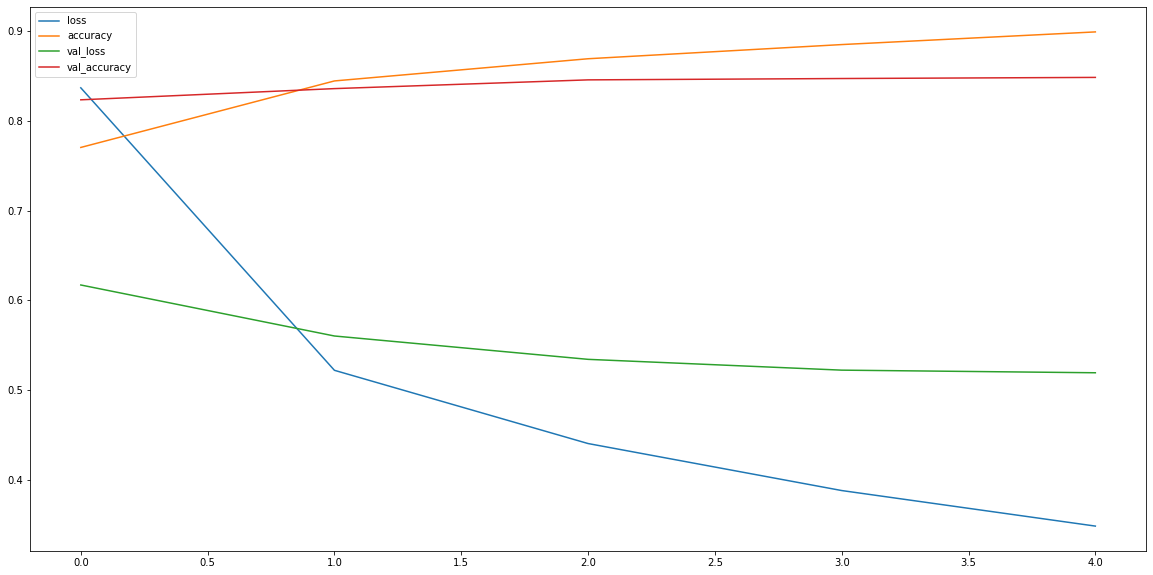

In [46]:
pd.DataFrame(eff_history.history).plot(figsize=(20,10))